In [1]:
import os
import time
import argparse
import numpy as np
from typing import Sequence

from dataset import fetch_data, DataTemplate
from model import LogisticRegression, NNLastLayerIF, MLPClassifier
from utils import fix_seed, save2csv

import json

import pickle
import random

import copy

import pandas as pd

from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling, margin_sampling, uncertainty_sampling

from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
 
from modAL.utils.selection import shuffled_argmax, shuffled_argmin

/home/wxxiao/anaconda3/envs/tf-py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def parse_args():
    parser = argparse.ArgumentParser(description='Influence Fairness')
    parser.add_argument('--dataset', type=str, default="adult", help="name of the dataset")
    parser.add_argument('--metric', type=str, default="eop", help="eop or dp")
    parser.add_argument('--seed', type=float, default=42, help="random seed")
    parser.add_argument('--save_model', type=str, default="n", help="y/n")
    parser.add_argument('--type', type=str, default="util", help="util/fair/robust")
    parser.add_argument('--strategy', type=str, default="dec", help="inc/dec/random")
    parser.add_argument('--points_to_delete', type=int, default=500, help="points to delete")
    parser.add_argument('--random_seed', type=int, default=42, help="seed for random strategy")
    parser.add_argument('--plot_before_only', type=str, default="n", help="y/n")
    parser.add_argument('--model_type', type=str, default="logreg", help="logreg/nn")
    parser.add_argument('--diabetes', type=str, default="y", help="y/n")

    args = parser.parse_args("--dataset bank --diabetes  n --plot_before_only n".split())

    return args
args = parse_args()

In [3]:
def get_full_dataset(args):
    tik = time.time()

    if args.seed is not None:
        fix_seed(args.seed)

    with open('data/' + args.dataset  + '/meta.json', 'r+') as f:
        json_data = json.load(f)
        json_data['train_path'] = './data/' + args.dataset + '/train.csv'
        f.seek(0)        
        json.dump(json_data, f, indent=4)
        f.truncate()

    data: DataTemplate = fetch_data(args.dataset)
    return data

def random_sampling(classifier, X_pool, n_instances):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples), n_instances, replace=False)
    return query_idx, X_pool[query_idx]



def train_model(args, x_train, y_train):
    tik = time.time()

    if args.seed is not None:
        fix_seed(args.seed)

    model = LogisticRegression(l2_reg=0.01)

    """ vanilla training """

    model.fit(x_train, y_train)

    return model


def compute_influence(args, x_train, y_train, x_val, y_val, model):
    ori_util_loss_val = model.log_loss(x_val,y_val)

    """ compute the influence and save data """

    pred_train, _ = model.pred(x_train)

    train_total_grad, train_indiv_grad = model.grad(x_train, y_train)
    util_loss_total_grad, acc_loss_indiv_grad = model.grad(x_val, y_val)

    hess = model.hess(x_train)
    util_grad_hvp = model.get_inv_hvp(hess, util_loss_total_grad)

    util_pred_infl = train_indiv_grad.dot(util_grad_hvp)

    return util_pred_infl

In [4]:
args.seed = 0
#args.dataset = 'toy'
#args.diabetes = 'y'
N_QUERIES = 10 #100
N_ROUNDS = 10

base_model = clf = make_pipeline(StandardScaler(), LogisticRegression(l2_reg=0.01))

# base_model = LogisticRegression(l2_reg=0.01)
#######################
data = get_full_dataset(args)

Loading Bank dataset..
Dataset statistic - #total: 30488; #train: 18292; #val.: 6098; #test: 6098; #dim.: 51



In [5]:
X_pool, X_init, y_pool, y_init = train_test_split(data.x_train, data.y_train, train_size=data.x_train.shape[0] - 300, test_size=300, random_state=1, stratify=data.y_train)

X_pool_copy, y_pool_copy = copy.deepcopy(X_pool), copy.deepcopy(y_pool)

# data.x_val, data.y_val, data.x_test, data.y_test = X_val, y_val, X_test, y_test

X_init.shape[0], X_pool.shape[0], data.x_val.shape[0], data.x_test.shape[0]

(300, 17992, 6098, 6098)

In [6]:
val_shape = data.x_val.shape[0]
X_all = np.concatenate((data.x_val, X_pool), axis=0)
y_all = np.concatenate((data.y_val, y_pool), axis=0)

random_seed = 2026
X_pool, X_val, y_pool, y_val = train_test_split(X_all, y_all, train_size=X_all.shape[0] - val_shape, test_size=val_shape, random_state=random_seed, stratify=y_all)
data.x_val, data.y_val = X_val, y_val
X_init.shape[0], X_pool.shape[0], data.x_val.shape[0], data.x_test.shape[0]

y_pool_copy = copy.deepcopy(y_pool)

np.random.seed(random_seed)

In [7]:
C = 50
base_model = make_pipeline(LogisticRegression(C))

x_init = X_init
x_val = data.x_val
x_test = data.x_test

x_pool = X_pool
y_pool_copy = copy.deepcopy(y_pool)

x_pool_copy = copy.deepcopy(x_pool)

In [8]:
#Random Sampling
rlearner = ActiveLearner(
estimator=base_model,
query_strategy=random_sampling,
X_training=x_init, y_training=y_init)

unqueried_score = rlearner.score(x_test, data.y_test)
val_score = rlearner.score(x_val, data.y_val)

results_dict = {'random':[unqueried_score], 'entropy':[unqueried_score], 'margin':[unqueried_score], 'influence':[unqueried_score], 'uncertainty':[unqueried_score], 'p_influence':[unqueried_score], 
                'random_val':[val_score], 'entropy_val':[val_score], 'margin_val':[val_score], 'influence_val':[val_score], 'uncertainty_val':[val_score], 'p_influence_val':[val_score]}

for _ in range(N_ROUNDS):
    query_index, query_instance = rlearner.query(x_pool, n_instances=N_QUERIES)

    x_teach, y_teach = x_pool[query_index].reshape(N_QUERIES, -1), y_pool[query_index].reshape(N_QUERIES, )
    rlearner.teach(X=x_teach, y=y_teach)

    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

    rmodel_accuracy = rlearner.score(x_test, data.y_test)
    results_dict['random'].append(rmodel_accuracy)
    results_dict['random_val'].append(rlearner.score(x_val, data.y_val))

x_pool, y_pool = copy.deepcopy(x_pool_copy), copy.deepcopy(y_pool_copy)

print("RANDOM SAMPLING DONE.")

results_dict['random']

RANDOM SAMPLING DONE.


[0.6589045588717612,
 0.6552968186290588,
 0.6602164644145622,
 0.6500491964578551,
 0.6564447359790095,
 0.6566087241718597,
 0.6644801574286652,
 0.6672679567071171,
 0.6689078386356182,
 0.6766152836995736,
 0.6713676615283699]

In [9]:
#Entropy Sampling
elearner = ActiveLearner(
estimator=base_model,
query_strategy=entropy_sampling,
X_training=x_init, y_training=y_init)


for _ in range(N_ROUNDS):
    query_index, query_instance = elearner.query(x_pool, n_instances=N_QUERIES)

    x_teach, y_teach = x_pool[query_index].reshape(N_QUERIES, -1), y_pool[query_index].reshape(N_QUERIES, )
    elearner.teach(X=x_teach, y=y_teach)

    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

    emodel_accuracy = elearner.score(x_test, data.y_test)
    results_dict['entropy'].append(emodel_accuracy)
    results_dict['entropy_val'].append(elearner.score(x_val, data.y_val))

    
x_pool, y_pool = copy.deepcopy(x_pool_copy), copy.deepcopy(y_pool_copy)

print("ENTROPY SAMPLING DONE.")
results_dict['entropy']

ENTROPY SAMPLING DONE.


[0.6589045588717612,
 0.664316169235815,
 0.6651361102000656,
 0.6710396851426698,
 0.672843555264021,
 0.6777632010495245,
 0.6853066579206297,
 0.6931780911774352,
 0.7099048868481469,
 0.7190882256477533,
 0.7256477533617579]

In [10]:
#Margin Sampling
mlearner = ActiveLearner(
estimator=base_model,
query_strategy=margin_sampling,
X_training=x_init, y_training=y_init)

for _ in range(N_ROUNDS):
    query_index, query_instance = mlearner.query(x_pool, n_instances=N_QUERIES)

    x_teach, y_teach = x_pool[query_index].reshape(N_QUERIES, -1), y_pool[query_index].reshape(N_QUERIES, )
    mlearner.teach(X=x_teach, y=y_teach)

    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

    mmodel_accuracy = mlearner.score(x_test, data.y_test)
    results_dict['margin'].append(mmodel_accuracy)
    results_dict['margin_val'].append(mlearner.score(x_val, data.y_val))

x_pool, y_pool = copy.deepcopy(x_pool_copy), copy.deepcopy(y_pool_copy)

print("MARGIN SAMPLING DONE.")
results_dict['margin']

MARGIN SAMPLING DONE.


[0.6589045588717612,
 0.664316169235815,
 0.6651361102000656,
 0.6710396851426698,
 0.672843555264021,
 0.6777632010495245,
 0.6853066579206297,
 0.6931780911774352,
 0.7099048868481469,
 0.7190882256477533,
 0.7256477533617579]

In [11]:
#Uncertainty Sampling
ulearner = ActiveLearner(
estimator=base_model,
query_strategy=uncertainty_sampling,
X_training=x_init, y_training=y_init)

for _ in range(N_ROUNDS):
    query_index, query_instance = ulearner.query(x_pool, n_instances=N_QUERIES)

    x_teach, y_teach = x_pool[query_index].reshape(N_QUERIES, -1), y_pool[query_index].reshape(N_QUERIES, )
    ulearner.teach(X=x_teach, y=y_teach)

    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

    umodel_accuracy = ulearner.score(x_test, data.y_test)
    results_dict['uncertainty'].append(umodel_accuracy)
    results_dict['uncertainty_val'].append(ulearner.score(x_val, data.y_val))
    
x_pool, y_pool = copy.deepcopy(x_pool_copy), copy.deepcopy(y_pool_copy)

print("UNCERTAINTY SAMPLING DONE.")
results_dict['uncertainty']

UNCERTAINTY SAMPLING DONE.


[0.6589045588717612,
 0.664316169235815,
 0.6651361102000656,
 0.6710396851426698,
 0.672843555264021,
 0.6777632010495245,
 0.6853066579206297,
 0.6931780911774352,
 0.7099048868481469,
 0.7190882256477533,
 0.7256477533617579]

In [12]:
cls_model = train_model(args, X_init, y_init)
util_infl = compute_influence(args, X_init, y_init, data.x_val, data.y_val, cls_model)
estimation_model = DecisionTreeRegressor(random_state=42).fit(X_init, util_infl)
def influence_sampling(classifier, x_pool, n_instances=1):
    I = estimation_model.predict(x_pool)
    query_idx, query_I = shuffled_argmax(I, n_instances=n_instances)
    return query_idx, x_pool[query_idx]

#Influence Sampling
ilearner = ActiveLearner(
estimator=base_model,
query_strategy=influence_sampling,
X_training=x_init, y_training=y_init)

for _ in range(N_ROUNDS):
    query_index, query_instance = ilearner.query(x_pool, n_instances=N_QUERIES)

    x_teach, y_teach = x_pool[query_index].reshape(N_QUERIES, -1), y_pool[query_index].reshape(N_QUERIES, )

    ilearner.teach(X=x_teach, y=y_teach)

    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

    imodel_accuracy = ilearner.score(x_test, data.y_test)
    results_dict['influence'].append(imodel_accuracy)
    results_dict['influence_val'].append(ilearner.score(x_val, data.y_val))
    
x_pool, y_pool = copy.deepcopy(x_pool_copy), copy.deepcopy(y_pool_copy)

print("INFLUENCE SAMPLING DONE.")
results_dict['influence']

INFLUENCE SAMPLING DONE.


[0.6589045588717612,
 0.6551328304362086,
 0.6448015742866514,
 0.6375860938012463,
 0.6426697277795999,
 0.64283371597245,
 0.6472613971794031,
 0.6403738930796983,
 0.6425057395867497,
 0.6416857986224992,
 0.6434896687438505]

In [13]:
def compute_influence(args, x_train, y_train, x_val, y_val, model):
    # ori_util_loss_val = model.log_loss(x_val,y_val)

    """ compute the influence and save data """
    
    _, train_indiv_grad = model.grad(x_train, y_train)

    util_loss_total_grad, acc_loss_indiv_grad = model.grad(x_val, y_val)

    hess = model.hess(x_train)
    util_grad_hvp = model.get_inv_hvp(hess, util_loss_total_grad)

    util_pred_infl = train_indiv_grad.dot(util_grad_hvp)

    return util_pred_infl

In [14]:
def p_inf_sampling(classifier, x_pool, n_instances=1):
    p_labels = pilearner.predict(x_pool)
    pool_infl = compute_influence(args, x_pool, p_labels, x_val, data.y_val, pilearner.estimator[0])
    query_idx, query_I = shuffled_argmax(pool_infl, n_instances=n_instances)
    return query_idx, x_pool[query_idx]

#P Influence Sampling
pilearner = ActiveLearner(
estimator=base_model,
query_strategy=p_inf_sampling,
X_training=x_init, y_training=y_init)

results_dict['p_influence'] = [unqueried_score]
results_dict['p_influence_val'] =  [val_score]


for _ in range(N_ROUNDS):
    query_index, query_instance = pilearner.query(x_pool, n_instances=N_QUERIES)

    x_teach, y_teach = x_pool[query_index].reshape(N_QUERIES, -1), y_pool[query_index].reshape(N_QUERIES, )

    pilearner.teach(X=x_teach, y=y_teach)

    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

    imodel_accuracy = pilearner.score(x_test, data.y_test)
    results_dict['p_influence'].append(imodel_accuracy)
    results_dict['p_influence_val'].append(pilearner.score(x_val, data.y_val))

x_pool, y_pool = copy.deepcopy(x_pool_copy), copy.deepcopy(y_pool_copy)

print("INFLUENCE SAMPLING DONE.")
results_dict['p_influence']

INFLUENCE SAMPLING DONE.


[0.6589045588717612,
 0.65710068875041,
 0.6597244998360118,
 0.6574286651361102,
 0.6620203345359135,
 0.6559527714004592,
 0.6615283699573631,
 0.6616923581502132,
 0.6653000983929157,
 0.6633322400787144,
 0.6521810429649065]

In [16]:
def compute_influence_auto(args, x_train, y_train, x_val, y_val, model):
    ori_util_loss_val = model.log_loss(x_val,y_val)

    """ compute the influence and save data """
    
    _, train_indiv_grad_0 = model.grad(x_train, np.zeros_like(y_train))
    _, train_indiv_grad_1 = model.grad(x_train, np.ones_like(y_train))

    util_loss_total_grad, acc_loss_indiv_grad = model.grad(x_val, y_val)

    hess = model.hess(x_train)
    util_grad_hvp = model.get_inv_hvp(hess, util_loss_total_grad)

    util_pred_infl_0 = train_indiv_grad_0.dot(util_grad_hvp)
    util_pred_infl_1 = train_indiv_grad_1.dot(util_grad_hvp)

    return util_pred_infl_0, util_pred_infl_1




def auto_inf_sampling(classifier, x_pool, n_instances=1):
    
    inf_0, inf_1 = compute_influence_auto(args, x_pool, np.zeros(shape=(x_pool.shape[0],)), x_val, data.y_val, auto_ilearner.estimator[0])

    query_metrics = np.maximum(inf_0, inf_1)
    
    query_idx, query_inf = shuffled_argmax(query_metrics, n_instances=n_instances)
    
    infs = inf_0 - inf_1
    return query_idx, infs[query_idx]


#P Influence Sampling
auto_ilearner = ActiveLearner(
estimator=base_model,
query_strategy=auto_inf_sampling,
X_training=x_init, y_training=y_init)

results_dict['a_influence'] = [unqueried_score]
results_dict['a_influence_val'] = [val_score]

for _ in range(N_ROUNDS):
    query_index, query_instance, inf_0_1 = auto_ilearner.query(x_pool, n_instances=N_QUERIES, return_metrics=True)

    # print(list(zip(inf_0_1, y_pool[query_index], np.where(np.array(inf_0_1)>0, 1, 0).reshape(N_QUERIES, ))))

    x_teach, y_teach = x_pool[query_index].reshape(N_QUERIES, -1), np.where(np.array(inf_0_1)>0, 0, 1).reshape(N_QUERIES, )


    auto_ilearner.teach(X=x_teach, y=y_teach)

    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

    imodel_accuracy = auto_ilearner.score(x_test, data.y_test)
    results_dict['a_influence'].append(imodel_accuracy)
    results_dict['a_influence_val'].append(auto_ilearner.score(x_val, data.y_val))
    
x_pool, y_pool = copy.deepcopy(x_pool_copy), copy.deepcopy(y_pool_copy)

print("auto INFLUENCE SAMPLING DONE.")
results_dict['a_influence']

auto INFLUENCE SAMPLING DONE.


[0.6589045588717612,
 0.648573302722204,
 0.6772712364709741,
 0.6976057723843884,
 0.7387668087897671,
 0.764348966874385,
 0.7718924237454903,
 0.7766480813381437,
 0.7820596917021975,
 0.7695965890455887,
 0.7745162348310921]

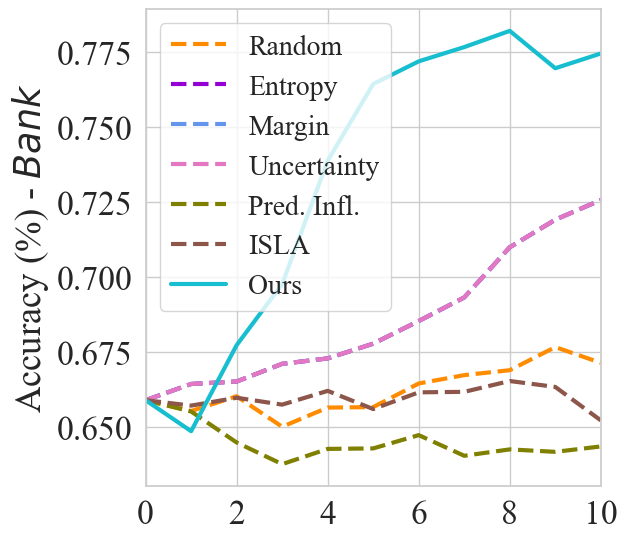

In [18]:
import seaborn as sns
sns.set(font_scale=2.2)

sns.set_style("whitegrid")
plt.figure(figsize=(6.7, 6), dpi=100)
plt.rcParams["font.family"] = "Times New Roman"
plt.rc('text', usetex = False)

args.dataset = 'wine_quality'
# plt.plot(range(11), results_dict['random'], label='Random', color='tab:orange', linestyle='dashed',lw=3)
plt.plot(range(11), results_dict['random'], label='Random', color='darkorange', linestyle='dashed',lw=3)
plt.plot(range(11), results_dict['entropy'], label='Entropy', color='darkviolet', linestyle='dashed',lw=3)
plt.plot(range(11), results_dict['margin'], label='Margin', color='cornflowerblue', linestyle='dashed',lw=3)
plt.plot(range(11), results_dict['uncertainty'], label='Uncertainty', color='tab:pink', linestyle='dashed',lw=3)
plt.plot(range(11), results_dict['influence'], label='Pred. Infl.', color='olive', linestyle='dashed',lw=3)
plt.plot(range(11), results_dict['p_influence'], label='ISLA', color='tab:brown', linestyle='dashed',lw=3)
# plt.plot(range(11), results_dict['diff_influence'], label='Influence w/o Auto-Labeling', linestyle='dashed', color='tab:red', lw=3)
plt.plot(range(11), results_dict['a_influence'], label='Ours', color='tab:cyan', lw=3)
# plt.plot(range(11), results_dict['r_influence'], label='Auto-Labeling Reversed Influence', color='darkviolet', lw=3)


# plt.xlabel('Active Rounds')
plt.ylabel('Accuracy (%) - $\it{Bank}$')
legend = plt.legend(loc="upper left", fontsize=20)
legend.get_frame().set_alpha(0.8)

# plt.title(args.dataset + ' Test Dataset')
# tight layout
# plt.ylim(0.63, 0.805)
# plt.yticks(np.linspace(0.63, 0.805, num=6), ["{0:.1f}".format(x) for x in np.linspace(0.63, 0.805, num=6)*100])
plt.xlim(0, 10)
plt.xticks(range(0, 11, 2))
plt.tight_layout()
# savename = 'newresults/'+ args.dataset + '_test_' + str(C) +'_influence_sampling.png'
plt.show()